In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats.mstats import winsorize

In [173]:
df = pd.read_excel("/Users/jothiprakash/Documents/Course/Final Project/Data/Midterm /onworkdata_cean.xlsx",index_col=[0])

In [175]:
df = df[[ 'Total number of transactions processed']]

In [176]:
# window_size = 7  # Example window size of 7 days
# rolling_mean = df['Total number of transactions processed'].rolling(window=window_size, min_periods=1).mean()
# df['Total number of transactions processed'] = df['Total number of transactions processed'].replace(0, float('nan'))

# df['Total number of transactions processed'] = df['Total number of transactions processed'].fillna(rolling_mean)

In [177]:
df['Total number of transactions processed'].head()

Date
2018-01-01      312
2018-01-02    14307
2018-01-03    16070
2018-01-04    17354
2018-01-05    15226
Name: Total number of transactions processed, dtype: int64

In [194]:
df = df.rolling(window=14).mean()
df = df.dropna()

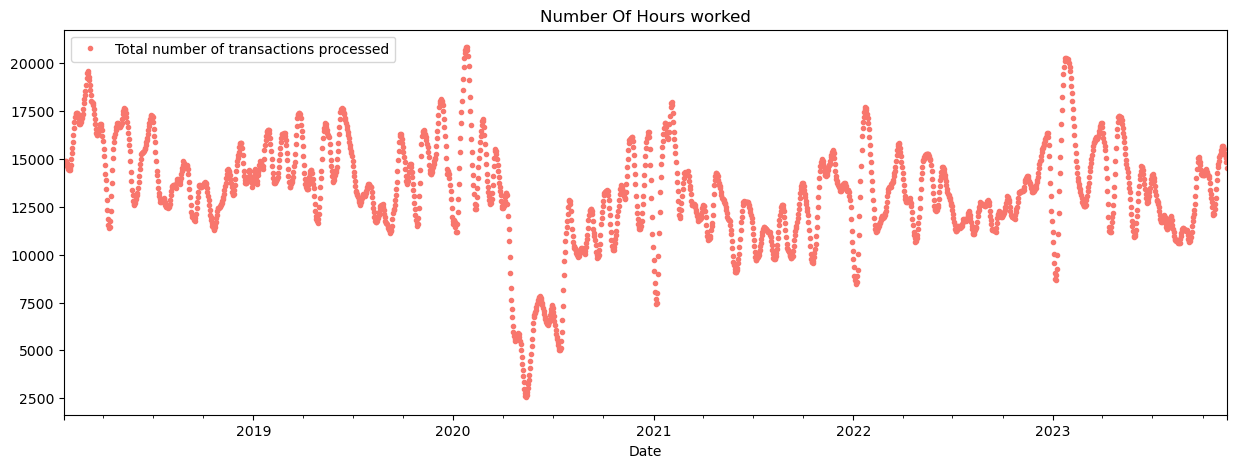

In [195]:
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='Number Of Hours worked')
plt.show()

In [196]:
def create_features(df, label=None):

    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='Total number of transactions processed')

features_and_target = pd.concat([X, y], axis=1)

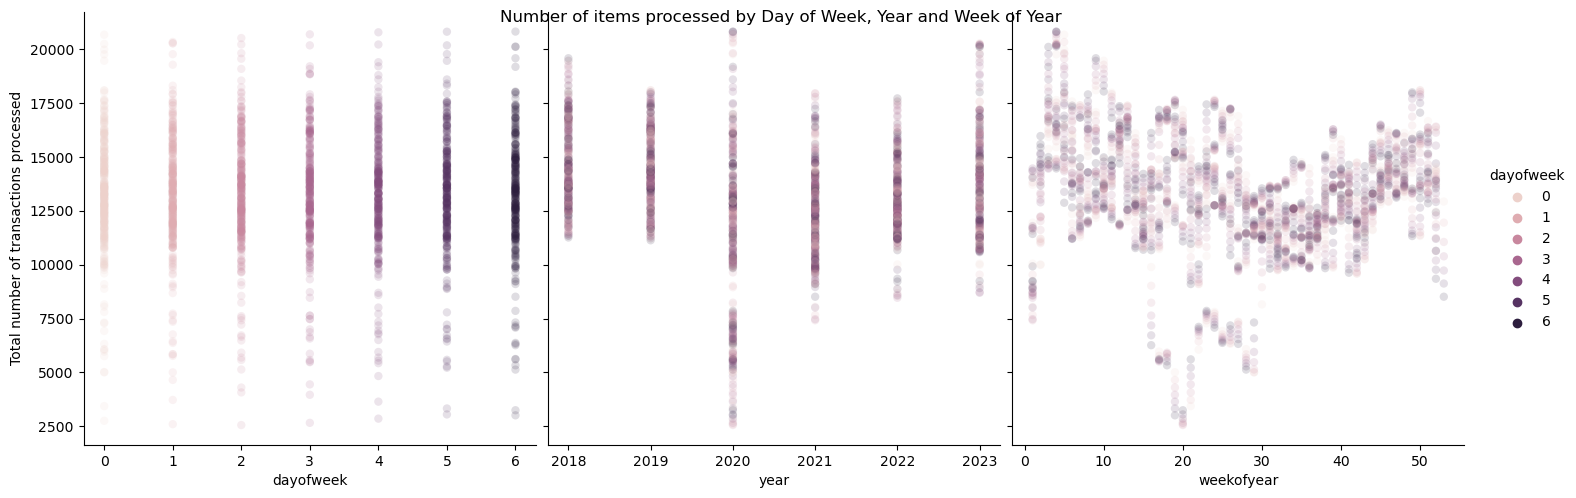

In [197]:
sns.pairplot(features_and_target.dropna(),
             hue='dayofweek',
             x_vars=['dayofweek',
                     'year','weekofyear'],
             y_vars='Total number of transactions processed',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Number of items processed by Day of Week, Year and Week of Year')
plt.show()

In [198]:
cutoff_date = '2022-09-10'  

# Split the data into training and testing sets
train = df.loc[df.index <= cutoff_date].copy()
test = df.loc[df.index > cutoff_date].copy()

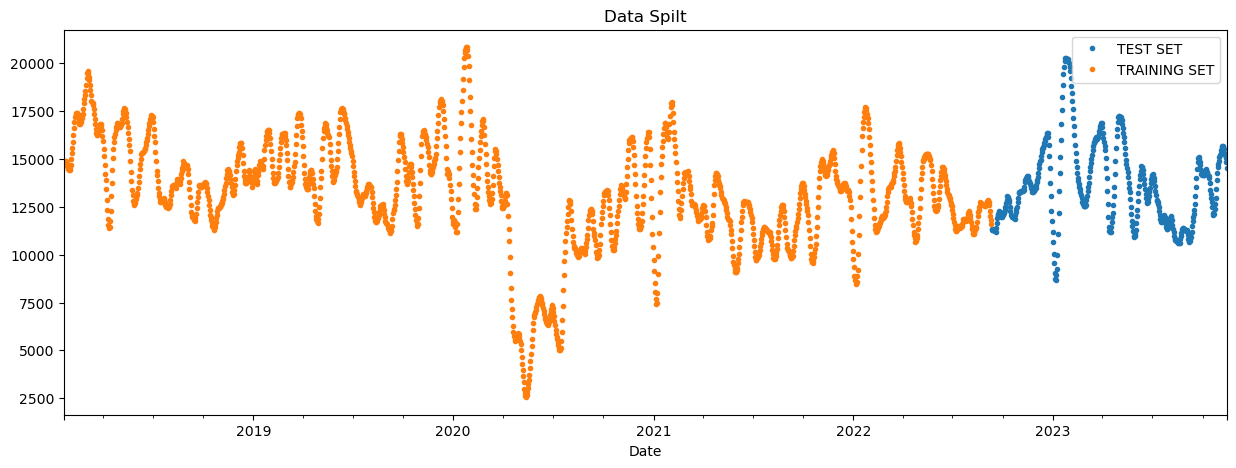

In [199]:
test\
    .rename(columns={'Total number of transactions processed': 'TEST SET'}) \
    .join(train.rename(columns={'Total number of transactions processed': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Data Spilt', style='.')
plt.show()

Simple Prophet 

In [200]:
train.reset_index() \
    .rename(columns={'Date':'ds',
                     'Total number of transactions processed':'y'}).head()

,ds,y
0,2018-01-20,14676.040816
1,2018-01-21,14853.734694
2,2018-01-22,14902.489796
3,2018-01-23,14910.306122
4,2018-01-24,14828.714286


In [201]:
model = Prophet(interval_width = 0.99, changepoint_range = 0.8,seasonality_mode = 'multiplicative')
model.add_country_holidays(country_name='CA')
model.fit(train.reset_index() \
              .rename(columns={'Date':'ds',
                               'Total number of transactions processed':'y'}))

09:36:42 - cmdstanpy - INFO - Chain [1] start processing
09:36:42 - cmdstanpy - INFO - Chain [1] done processing


In [202]:
test['Total number of transactions processed'].astype(int)

Date
2022-09-11    11363
2022-09-12    11301
2022-09-13    11289
2022-09-14    11275
2022-09-15    11263
              ...  
2023-11-10    15320
2023-11-11    15180
2023-11-12    15036
2023-11-13    14860
2023-11-14    14522
Name: Total number of transactions processed, Length: 430, dtype: int64

In [203]:
test_fcst = model.predict(df=test.reset_index() \
                                   .rename(columns={'Date':'ds'}))

In [204]:
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Canada Day,Canada Day_lower,Canada Day_upper,Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2022-09-11,13296.886375,7380.010929,15756.706492,13296.819859,13297.160526,0.0,0.0,0.0,0.0,...,-0.000078,-0.000078,-0.000078,-0.138927,-0.138927,-0.138927,0.0,0.0,0.0,11448.543472
1,2022-09-12,13299.102601,7306.625129,15444.238883,13295.177529,13301.009302,0.0,0.0,0.0,0.0,...,-0.000259,-0.000259,-0.000259,-0.138221,-0.138221,-0.138221,0.0,0.0,0.0,11457.439950
2,2022-09-13,13301.318827,7192.808878,15693.012916,13291.149266,13308.931004,0.0,0.0,0.0,0.0,...,0.000221,0.000221,0.000221,-0.135787,-0.135787,-0.135787,0.0,0.0,0.0,11498.102306
3,2022-09-14,13303.535053,7342.396762,15328.908724,13286.585785,13317.046633,0.0,0.0,0.0,0.0,...,0.000227,0.000227,0.000227,-0.131590,-0.131590,-0.131590,0.0,0.0,0.0,11555.938243
4,2022-09-15,13305.751279,7554.264242,15775.069234,13282.022304,13330.969969,0.0,0.0,0.0,0.0,...,0.000651,0.000651,0.000651,-0.125645,-0.125645,-0.125645,0.0,0.0,0.0,11642.600639


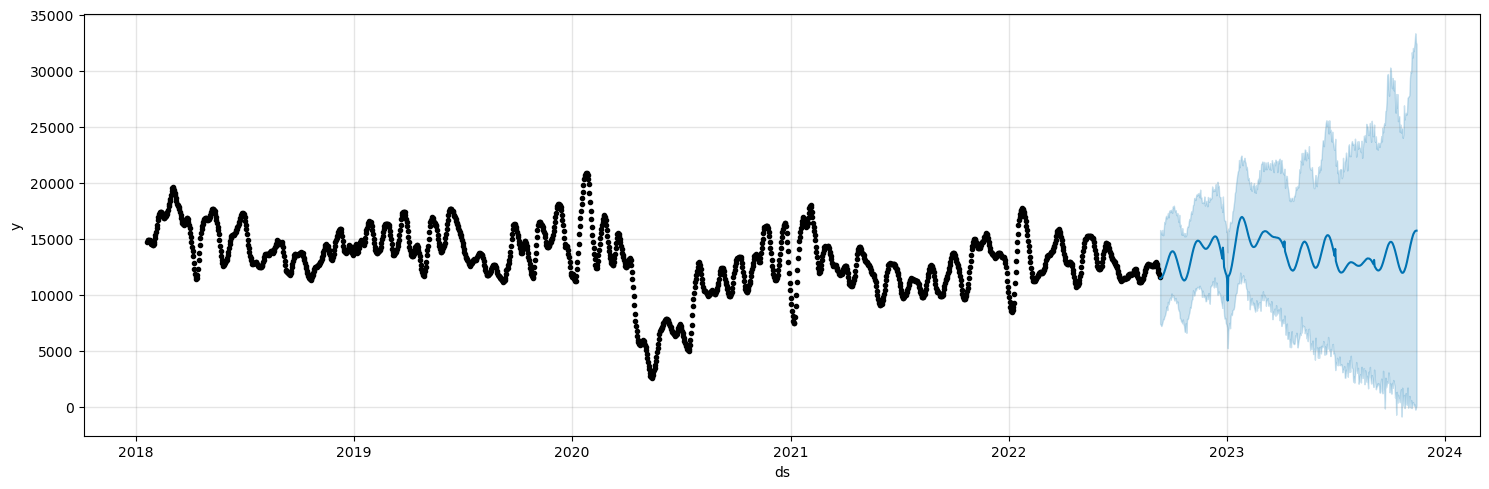

In [205]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(test_fcst,
                 ax=ax)
plt.show()

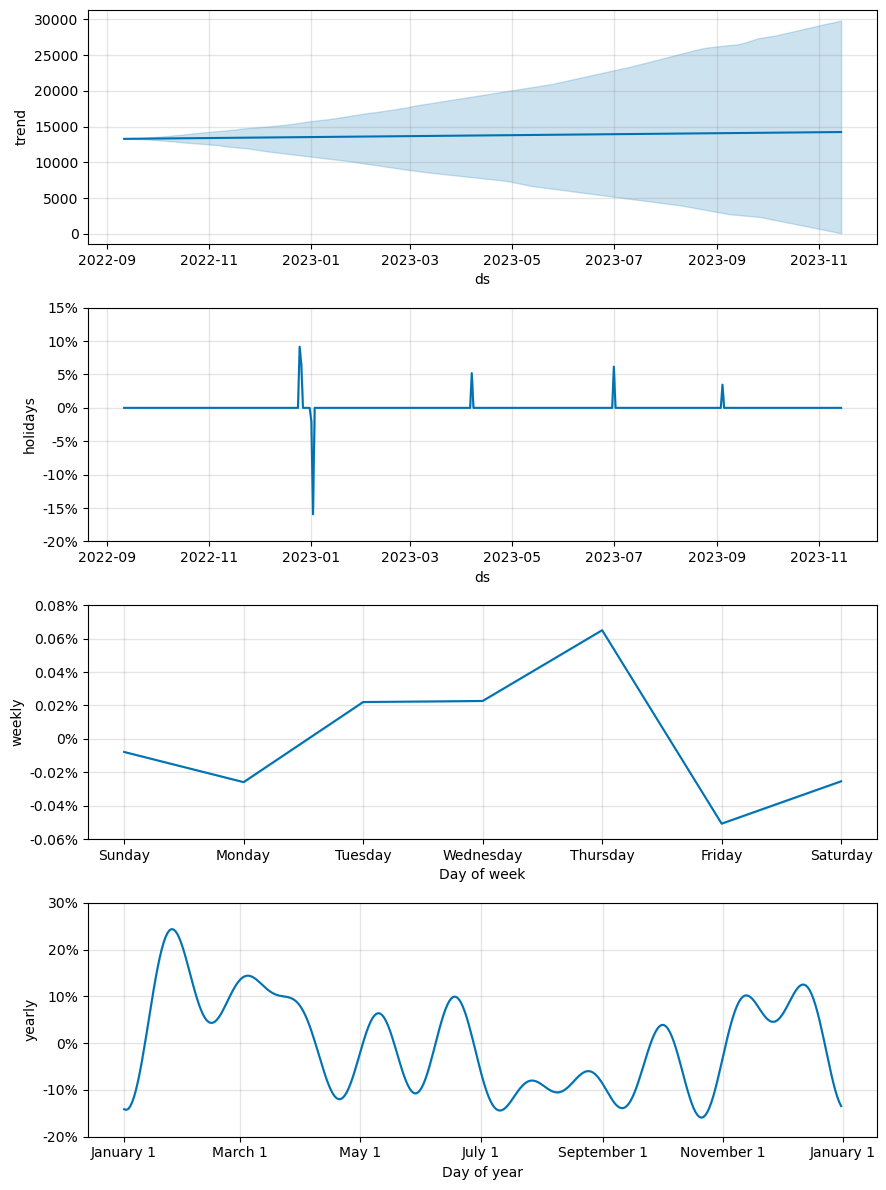

In [206]:
fig = model.plot_components(test_fcst)

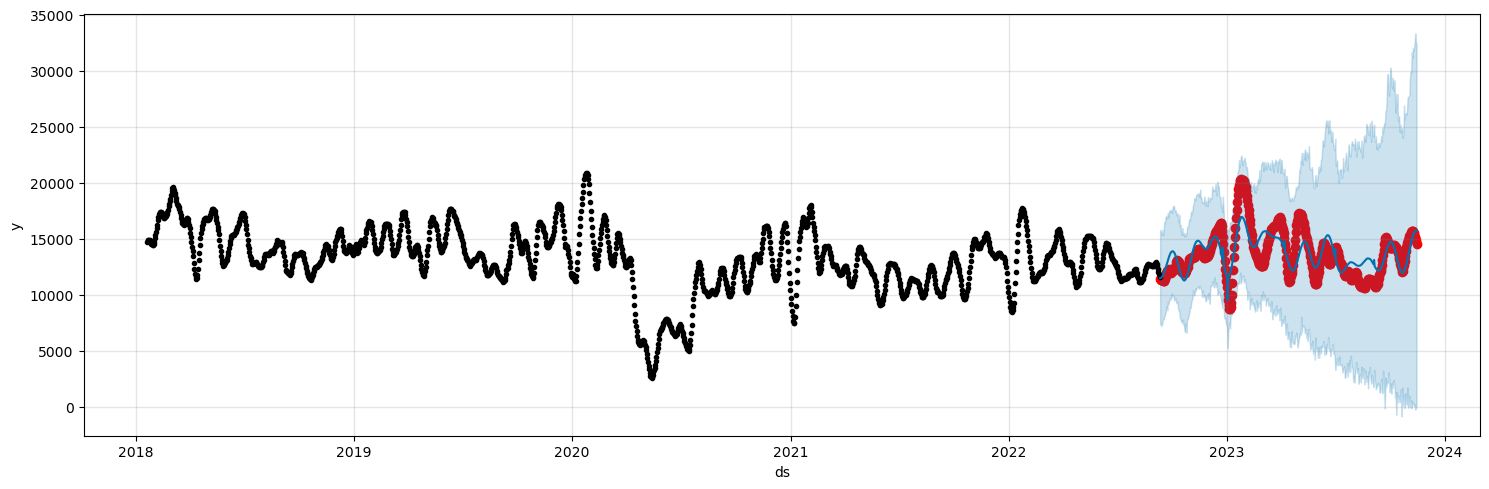

In [207]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['Total number of transactions processed'], color='r')
fig = model.plot(test_fcst, ax=ax)

In [208]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=test['Total number of transactions processed'],
                   y_pred=test_fcst['yhat'])

8.782146213597109

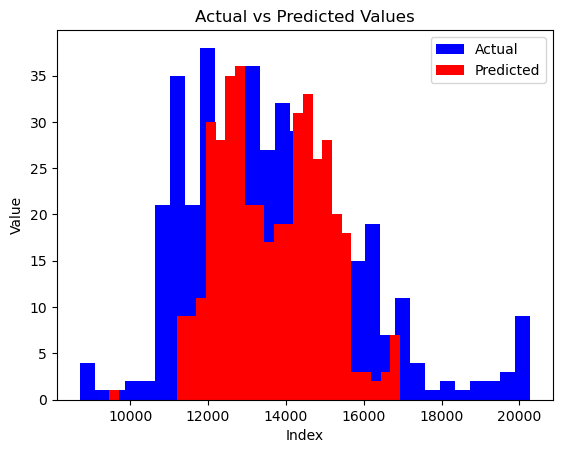

In [209]:
plt.hist( test['Total number of transactions processed'],  bins=30,color='blue', label='Actual')

# Plot predicted values
plt.hist(test_fcst['yhat'], color='red', bins=30, label='Predicted')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()